# Homework 05 - Taming text

## Import

In [1]:
import community
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re

from collections import Counter
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn import preprocessing

%matplotlib inline

# Our code (autoreload enabled - useful in developement mode)
%load_ext autoreload
%autoreload 1
%aimport utils

**IMPORTANT NOTE:** For readability reasons, we decide to store all defined functions in a file called *utils.py*. When functions are used in a cell, a comment mentions it (*# UTILS: use of &lt;name of function 1&gt;[, &lt;name of function 2&gt;, ...]*).

If some components are missing, please uncomment the following line and execute the cell in order to start the download utility of nltk.

In [2]:
# nltk.download()

## Preliminary remarks

This Notebook is based on the <a href="https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy">Hillary Clinton email controversy</a>. Please note that only a fraction of the published emails are used here. The full list, which was published by U.S. Department of State under the Freedom of Information Act, can be consulted <a href="https://foia.state.gov/Learn/New.aspx">here</a>.

**Credits:** Background used in this Notebook was made by <a href="http://www.flaticon.com/authors/freepik" title="Freepik">Freepik</a> from <a href="http://www.flaticon.com" title="Flaticon">www.flaticon.com</a>.

# Import data

First, we import all data as DataFrames.

In [3]:
df_aliases = pd.read_csv('hillary-clinton-emails/Aliases.csv', index_col=0)

In [4]:
df_aliases.head()

,Alias,PersonId
Id,,
1,111th congress,1
2,agna usemb kabul afghanistan,2
3,ap,3
4,asuncion,4
5,alec,5


In [5]:
df_email_receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv', index_col=0)

In [6]:
df_email_receivers.head()

,EmailId,PersonId
Id,,
1,1,80
2,2,80
3,3,228
4,3,80
5,4,80


In [7]:
df_emails = pd.read_csv('hillary-clinton-emails/Emails.csv', index_col=0)
df_emails.fillna('', inplace=True)
df_emails.replace({'\n': ' '}, regex=True, inplace=True)

In [8]:
df_emails.head()

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,...,,"Sullivan, Jacob J <Sullivan11@state.gov>",,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,UNCLASSIFIED U.S. Department of State Case No....
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,,,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,...,,,,,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6 Thursday, March 3, 2011 9:45 PM H: Latest H...",UNCLASSIFIED U.S. Department of State Case No....
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED U.S. Department of State Case No....
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,...,,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,,UNCLASSIFIED U.S. Department of State Case No....
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,...,,,,,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com> Friday, March 11, ...",B6 UNCLASSIFIED U.S. Department of State Case ...


In [9]:
df_persons = pd.read_csv('hillary-clinton-emails/Persons.csv', index_col=0)

In [10]:
df_persons.head()

,Name
Id,
1,111th Congress
2,AGNA USEMB Kabul Afghanistan
3,AP
4,ASUNCION
5,Alec


# Handling raw text

First, we retrieve all the content using two columns: *MetadataSubject* and *ExtractedBodyText*. These columns contain respectively the core title and the body of each email in integrality.

In [11]:
emails_content = df_emails['MetadataSubject'] + ' ' + df_emails['ExtractedBodyText']
raw_text = ' '.join(emails_content.values)

Let's display first word cloud of the raw text, before any processing pipeline.

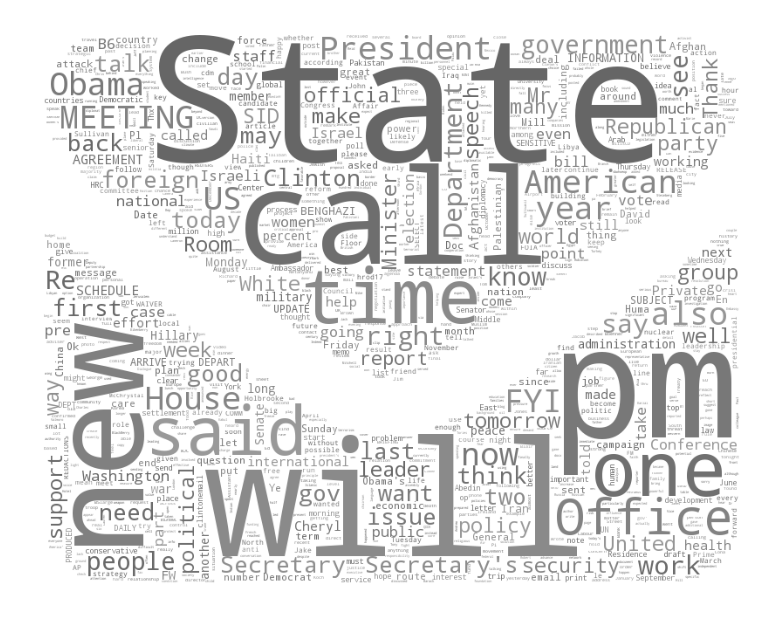

In [12]:
# UTILS: use of generate_word_cloud
word_cloud = utils.generate_word_cloud(raw_text, file_name='0_raw_text')
word_cloud.show()

# Q1 - Processing pipeline (cleaning of the text)

**Generate a word cloud based on the raw corpus -- I recommend you to use the Python word_cloud library. With the help of nltk (already available in your Anaconda environment), implement a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and cons (if any) of the two word clouds you generated.**

First, we tokenize the retrieved text. Here, we focus on each word as an all, thanks to a RegExp tokenizer.

After the processing, each token will be a candidate for an index entry.

In [13]:
# UTILS: use of REGEX_TOKENIZER
tokens = utils.REGEX_TOKENIZER.tokenize(raw_text)
word_tokenized_text = ' '.join(tokens)

Let's visualize if there are differences between word clouds describing, respectively, raw text and tokenized text.

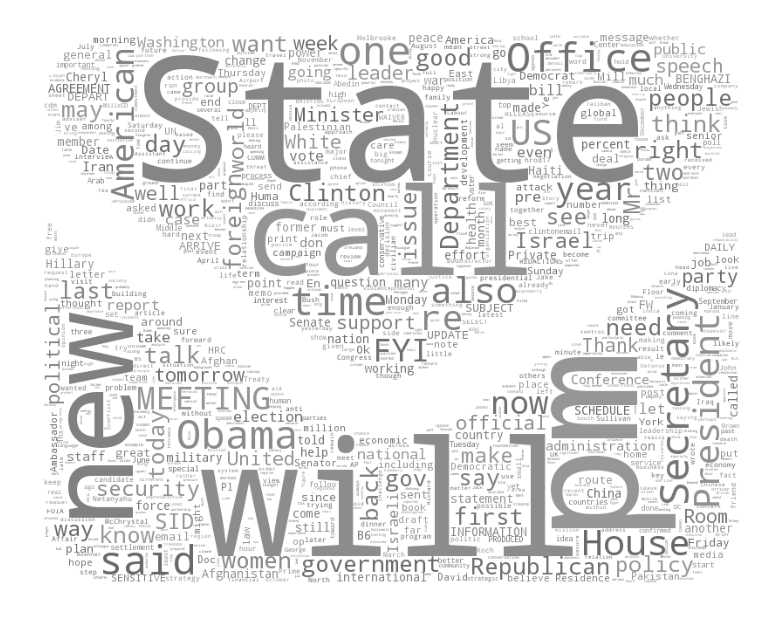

In [14]:
# UTILS: use of generate_word_cloud
word_cloud_tokenize = utils.generate_word_cloud(text=word_tokenized_text, file_name='1_word_tokenize')
word_cloud_tokenize.show()

As we can see - and it is not really surprising - there is no significant changes after the tokenization part. Note that using the default tokenizer, we would end up with some words like "n't" (which come from the decomposition of 'don't' in this case). Using Regexp tokenizer permit us to avoid such problems.

Now, we want to remove all meaningless words which are present in the emails. Here, we use a set of English words defined as 'stopwords', assuming that all emails were written in such language.

Also, some words, which are specific to the study, don't bring anything to our analysis and, in contrary, pollute it. Thus, we decide to remove them.

In [15]:
filtered_words = [word for word in tokens if word not in stopwords.words('english')]
filtered_text = ' '.join(filtered_words)

In [16]:
# UTILS: use of SPECIFIC_STOP_WORDS
for word in utils.SPECIFIC_STOP_WORDS: 
    filtered_text = re.sub(r'\b%s\b' % word, '', filtered_text, flags=re.IGNORECASE)

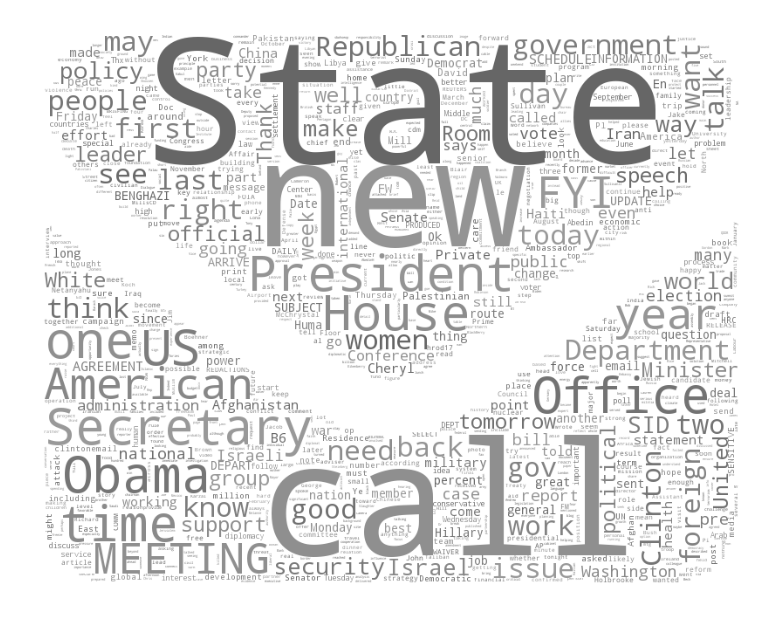

In [17]:
# UTILS: use of generate_word_cloud
word_cloud_stopwords = utils.generate_word_cloud(text=filtered_text, file_name='2_stopwords')
word_cloud_stopwords.show()

Note that even if we don't see big changes, the process removes for sure a lot of unwanted words, that may impact our further analysis if we don't remove them, and even if they don't appear as the most common ones.

In [18]:
print('Length before filtering: %d' % len(tokens))
print('Length after filtering: %d' % len(filtered_words))

Length before filtering: 661654
Length after filtering: 429574


Tokenize have some disadvantages for multiple reasons: 
* break up hyphenated sequence
* be unsensible to lower case
* usability/scalability.

This is why, we should use differents method : Lemmatization and stemming.

Now that we tokenized and filtered the content, we may want to apply lemmatization and stemming to obtain the most common words. Indeed, in such text, words are declined in different combinaisons and we must count all of these combinaisons as unique ones for the kind of analysis we run here.

**Note: About the difference between stemming and lemmatization**

The goal of both processes is to reduce inflectional forms or to find related forms of a word with a common base form ; however, the two techniques differ in the way they achieve to do it. Also, stemming was commonly implemented with reduction techniques, though this is not universal. Lemmatization, as for it, implies a possibly broader scope of functionality, which may include synonyms.

Let's firstly reduce inflectional (variant) forms to base form of the words.

In [19]:
#UTILS: use of WORDNET_LEMMATIZER
wl_text = utils.WORDNET_LEMMATIZER.lemmatize(filtered_text)

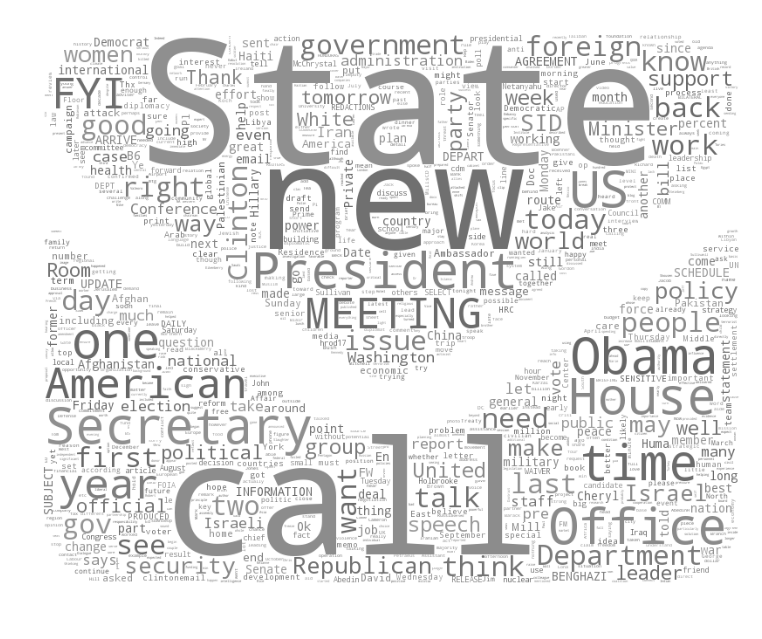

In [20]:
# UTILS: use of generate_word_cloud
word_cloud_lemmatizer = utils.generate_word_cloud(text=wl_text, file_name='3_WordNetLemmatizer')
word_cloud_lemmatizer.show()

Now, we use stemmer to reduce terms to their roots before indexing. Note that here we use both Porter stemmer, which is the most common.

In [21]:
# UTILS: use of do_stemming_words, PORTER_STEMMER
ps_stemming_text = utils.do_stemming_words(stemmer=utils.PORTER_STEMMER, words=wl_text)

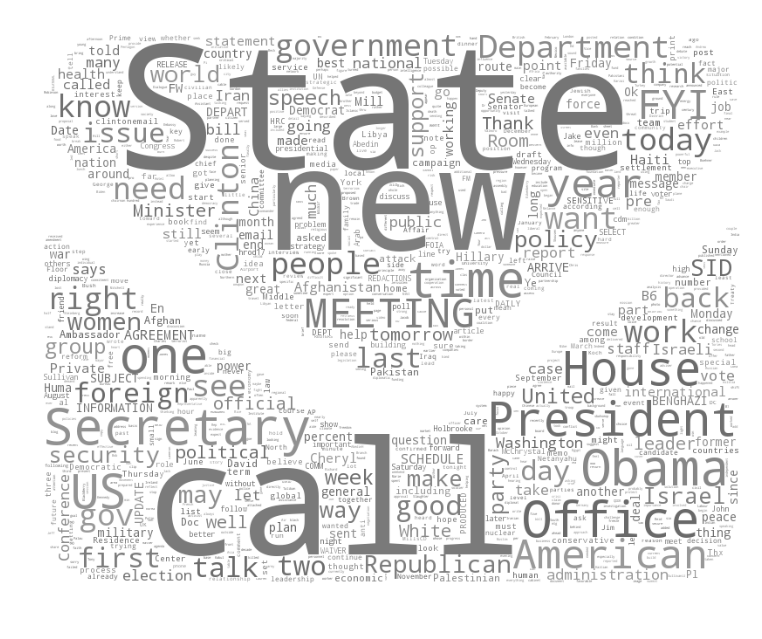

In [22]:
# UTILS: use of generate_word_cloud
word_cloud_porter_stemmer = utils.generate_word_cloud(text=ps_stemming_text, file_name='4_PorterStemmer')
word_cloud_porter_stemmer.show()

Just for curiosity, we can also use the Snowball stemmer to produce the same result. A good explanation was given about the differences between the main stemmer's algorithms <a href="http://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg">here</a>.

In [23]:
# UTILS: use of do_stemming_words, SNOWBALL_STEMMER
ss_stemming_text = utils.do_stemming_words(stemmer=utils.SNOWBALL_STEMMER, words=wl_text)

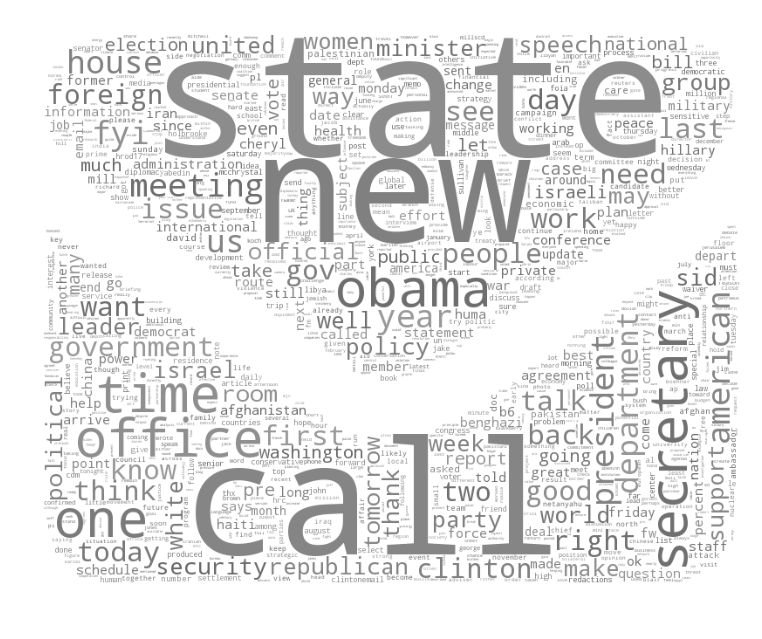

In [24]:
# UTILS: use of generate_word_cloud
word_cloud_stemmer = utils.generate_word_cloud(text=ss_stemming_text, file_name='4_SnowballStemmer')
word_cloud_stemmer.show()

Here, no big differences are observed between the two processing (respectively apply of Porter stemmer and Snowball stemmer).

# Q2 - Analysis on countries

**Find all the mentions of world countries in the whole corpus, using the pycountry utility (HINT: remember that there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) Perform sentiment analysis on every email message using the demo methods in the nltk.sentiment.util module. Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?**

### Processing data

First, we count all the occurrences of countries in Hillary Clinton's emails.

In [25]:
# UTILS: use of count_countries_occurrences
countries_occurrences = utils.count_countries_occurrences(ps_stemming_text)

In [26]:
df_countries_occurrences = pd.DataFrame.from_dict(countries_occurrences, orient='index')
df_countries_occurrences.columns = ['Occurrences']
df_countries_occurrences.sort_values('Occurrences', ascending=False, inplace=True)
df_countries_occurrences.head(15)

,Occurrences
Israel,1042
Libya,712
Haiti,515
United States,457
Afghanistan,430
Pakistan,408
China,407
Iraq,270
India,234
Oman,154


It is not surprising to find at the top of the list some countries like Israel, Libya, Haiti or even United States. Indeed, these countries are directly linked to the ex-Secretary of State!

Let's plot the 30 most quoted countries to have a better observation of what's going on.

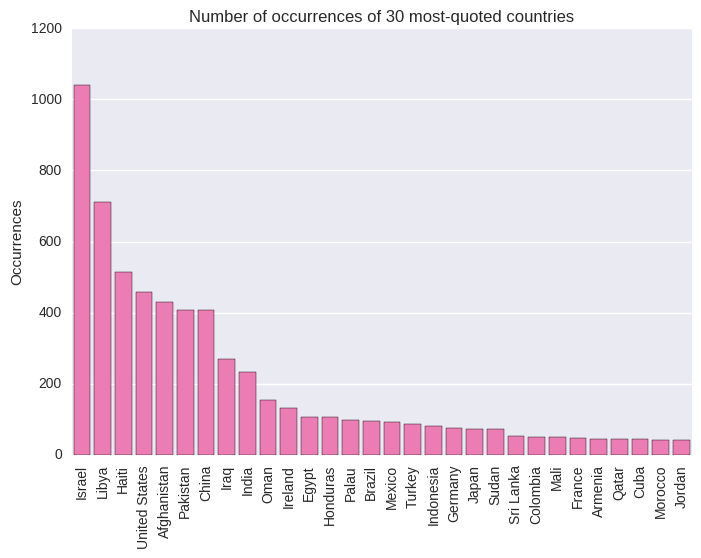

In [27]:
# UTILS: use of plot_most_quoted_countries
utils.plot_most_quoted_countries(df_countries_occurrences, 30)    

One can remark the fact that the number of quotes of a country drastically fall. We need to pay attention to this detail in the next part of the study as an insufficient number of occurrences could change the sense of the result!

### Sentimental Study

In this part, we want to attribute some kind of sentiment to each quoted country, according of what was discussed in the emails.
Sentiments is represented by a number computed from the context of the sentense where the country name appear.

*Note: For both analyzers, increment of positive and negative variables are done using returned score, and not in a static-way (e.g. increment of +1). Thus, we discriminate the case where the probability for a word (or a sentence) is high and another one where the probability for a word (respectively a sentence) is low, which is better. See details of the implementation in utils.py.*

*Note bis: We deliberately use SentiWordNet and Vader instead of provided demos as they are more effective and convenient to use in our context. We let reader check the documentation of NLTK if needed.*

In [28]:
df_emails_content = df_emails[['MetadataSubject', 'ExtractedBodyText']].copy()

We first use <a href="http://sentiwordnet.isti.cnr.it/">SentiWordNet</a> in order to retrieve the sentimal score of each email.

In [29]:
# UTILS: use of retrieve_email_sentiment
results = df_emails_content.apply(utils.retrieve_email_sentiment, axis=1)

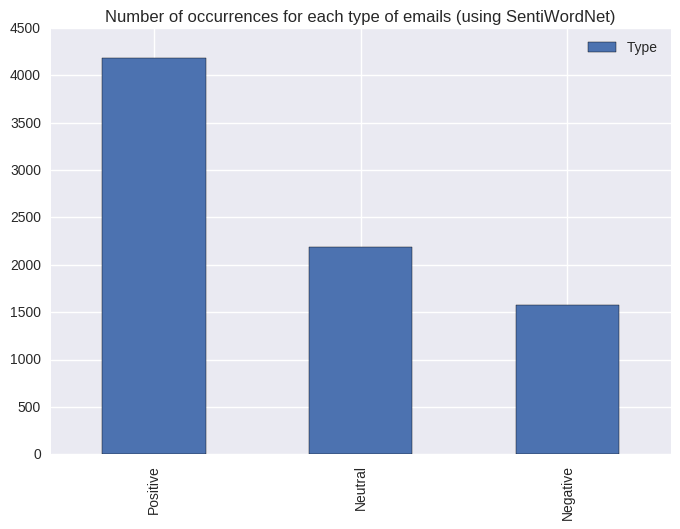

In [30]:
results_plot = pd.DataFrame(pd.value_counts(results['Type']))
results_plot.plot(kind='bar', title='Number of occurrences for each type of emails (using SentiWordNet)')

As we can notice from the previous graph, the number of positive emails is much more greater than the number of the neutral and negative ones.

Now let's use <a href="https://github.com/cjhutto/vaderSentiment">Vader sentiment analysis</a> to see if we obtain different results.

*Note: Some detailed examples on the performance of Vader sentiment analysis used in NLTK can be found <a href="http://www.nltk.org/howto/sentiment.html">here</a>.*

In [31]:
# UTILS: use of retrieve_email_sentiment
results_vader = df_emails_content.apply(utils.retrieve_email_sentiment, args=('Vader',), axis=1)

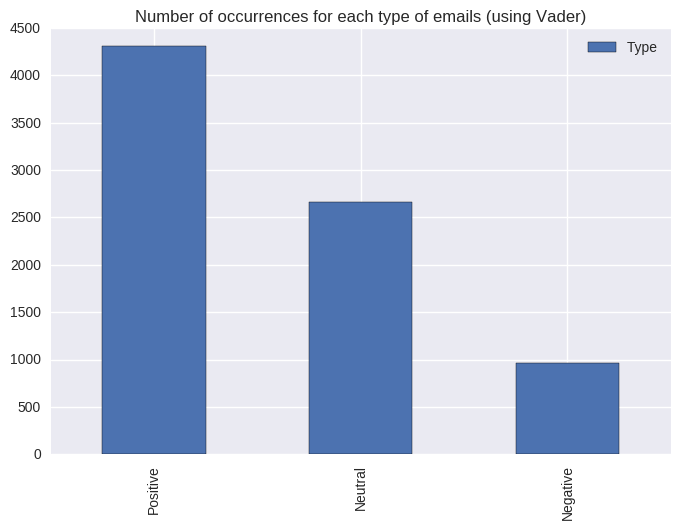

In [32]:
result_vader_plot = pd.DataFrame(pd.value_counts(results_vader['Type']))
result_vader_plot.plot(kind='bar', title='Number of occurrences for each type of emails (using Vader)')

Using Vader sentiment analysis, we obtain a different distribution of the data. This difference can be explained by the fact that algorithm associated with SentiWordNet doesn't take into account the entire sentence and only associates sentiment to each word, individually.

Now we have defined the sentiment of each email, let's define the sentiment associated to each country. Note that in order to avoid interferences, we only search for exact name of a country. Put in other words, we decide to ignore <a href="https://fr.wikipedia.org/wiki/ISO_3166-1_alpha-2">ISO 3166-1 alpha-2</a> and <a href="https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3">ISO 3166-1 alpha-3</a> country codes, as these codes can represent some words or abbreviations in English.

In [33]:
# UTILS: use of get_countries_sentiment
countries_sentiment = utils.get_countries_sentiment(results_vader)

In [34]:
df_countries_sentiment = pd.DataFrame.from_dict(countries_sentiment, orient='index')
df_countries_sentiment.columns = ['Sentiment']
df_countries_sentiment.sort_values('Sentiment', ascending=False, inplace=True)

In [35]:
df_countries_sentiment.head(10)

,Sentiment
Haiti,111
United States,68
India,55
Israel,53
Oman,50
Afghanistan,50
China,46
Pakistan,44
Iraq,34
Brazil,29


In [36]:
df_countries_sentiment.tail(10)

,Sentiment
Guinea-Bissau,-1
Burkina Faso,-1
Gabon,-1
Guam,-1
Lesotho,-1
Malta,-1
Switzerland,-2
South Sudan,-2
Serbia,-3
Libya,-21


Here, we display the 10 most-preferred and less-preferred countries, respectively, according to sentiment analysis. For some of them, there is explanations about the obtained score, even if it is not evident.

For good scores, and as an example, <a href="https://en.wikipedia.org/wiki/Haiti%E2%80%93United_States_relations">relations between Haiti and USA</a> can explain the obtained score. Also, even if USA was directly mobilized as part of Afghanistan's war, it does not mean that the sentiment toward this country is necessarily negative (quite the opposite!).

Now, regarding negative scores, some recent events may explain them, as for Libya (see <a href="https://en.wikipedia.org/wiki/2012_Benghazi_attack">2012 Benghazi attack</a> or <a href="https://en.wikipedia.org/wiki/Libyan_Civil_War_(2011)">Libyan Civil War of 2011</a>). Some historical reasons also justify the bad sentiment toward some countries like Serbia (see <a href="https://en.wikipedia.org/wiki/Serbia%E2%80%93United_States_relations">relations between Serbia and USA</a> and <a href="https://en.wikipedia.org/wiki/2008_Kosovo_declaration_of_independence">declaration of independence of Kosovo</a>).

### Plotting sentiment and occurrences

We merge occurrences and sentiment column in order to have all the information in an unique DataFrame.

In [37]:
countries_data = pd.merge(df_countries_occurrences, df_countries_sentiment, how='inner', left_index=True, right_index=True, sort=True)

As sentiment seems to decrease exponentially, we decide to adjust the values using MinMaxScaler. Moreover we have to apply the log function in order to decrease the difference of sentiment(number) for each country.

In [38]:
min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
countries_data[['Sentiment']] = np.log(countries_data['Sentiment'] + abs(min(countries_data['Sentiment'])) + 10)
countries_data['Sentiment'] = min_max_scaler.fit_transform(countries_data[['Sentiment']].as_matrix())

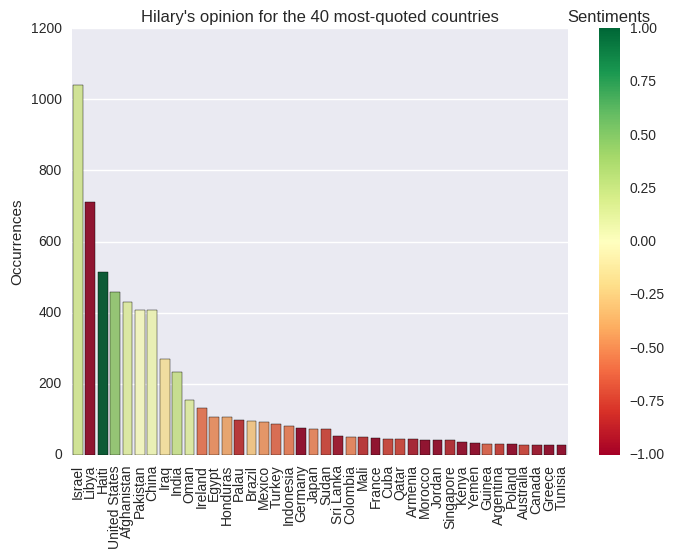

In [39]:
# UTILS: use of plot_countries_by_occurrences_and_sentiment
utils.plot_countries_by_occurrences_and_sentiment(countries_data, 40)

*Important note: Some results are more difficult to explain and are directly linked with the sentiment analyzers and their bias, but also with the fact that we ignored country codes during the process, while they are used in emails (it is about weighing up the pros and cons here). Also, and among other things, our assumptions and decisions explain the observed differences between different analysis on the same topic (see <a href="https://www.kaggle.com/operdeck/d/kaggle/hillary-clinton-emails/hillary-s-sentiment-about-countries">another example on Kaggle</a>).*

Let's also display the countries according to their score. Here, we display the 20 most-preferred countries (left side) and the 20 less-preferred countries (right side). **Here, colors represent the number of occurrences.**

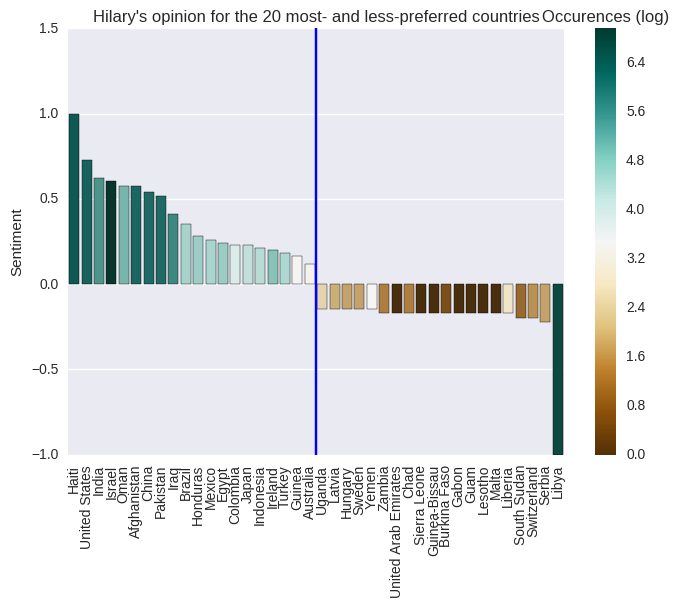

In [40]:
# UTILS: use of plot_sentiment_by_country
utils.plot_sentiment_by_country(countries_data, None, nb_country=20)

We can notice that except for few countries (Lativia, Serbia or Lybia), bad feeling seems to be linked with few occurences. Hence, for these countries, we must pay attention and don't make any definitive conclusions!

Note that, in contrary, it seems to be a correlation between good sentiment and number of occurrences for a given country, except for Libya...

# Q3 - Retrieve of the main topics

**Using the models.ldamodel module from the gensim library, run topic modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which returns topics that you consider to be meaningful at first sight.**

We want to draw attention on the fact that, in this part, we describe the topics manually. Put another way, the conclusions that are made here are subjective and may differ with the reader's ones.

We can be tempted to use automatic recognition of topics, but according to a research (<a href="http://machinelearning.wustl.edu/mlpapers/paper_files/NIPS2009_0125.pdf">see paper</a>), the better way to do this is to use human cognition when it comes to compare two LDA models (and this is even more true when two LDA models seem to by very close, as it is more difficult to conclude about the accuracy of the model itself).

## First method: using raw text

In this part, we use the raw text as source for creating our corpus and then the LDA model. No processing or strategies are applied at all.

So, first, we create our corpus using all content.

In [41]:
corpus_raw, id2word_raw = utils.create_corpus(df_emails['ExtractedBodyText'])

Then we create our LDA model with different number of topics.

Let's create LDA models with different number of topics and see if we observe significant differences.

In [42]:
lda_5_topics_raw = utils.create_lda_model(corpus_raw, id2word_raw, 5)
lda_5_topics_raw.print_topics()

[(0,
  '0.007*2010 + 0.003*2 + 0.003*new + 0.003*• + 0.003*- + 0.002*re: + 0.002*— + 0.002*also + 0.002*1 + 0.002*mr.'),
 (1,
  '0.009*fyi + 0.008*call + 0.005*see + 0.005*know + 0.004*h + 0.004*— + 0.004*pls + 0.004*pm + 0.004*2010 + 0.003*-'),
 (2,
  '0.005*would + 0.004*one + 0.003*like + 0.003*said + 0.003*could + 0.003*get + 0.002*president + 0.002*people + 0.002*new + 0.002*party'),
 (3,
  '0.005*- + 0.005*would + 0.004*new + 0.004*obama + 0.003*u.s. + 0.003*president + 0.003*one + 0.003*american + 0.003*said + 0.003*also'),
 (4,
  "0.031*pm + 0.016*office + 0.012*secretary's + 0.009*state + 0.008*meeting + 0.006*department + 0.006*2010 + 0.006*arrive + 0.006*route + 0.005*room")]

As we can see, and as expected, the topics are not so similar. These topics are about the 44th President of the United States (Barack Obama) and some business related with Secretary's job.

In [43]:
lda_10_topics_raw = utils.create_lda_model(corpus_raw, id2word_raw, 10)
lda_10_topics_raw.print_topics(10)

[(0,
  '0.004*party + 0.004*would + 0.004*new + 0.003*tea + 0.003*people + 0.003*us + 0.002*american + 0.002*government + 0.002*health + 0.002*one'),
 (1,
  '0.006*obama + 0.005*president + 0.005*israel + 0.004*2010 + 0.004*israeli + 0.004*would + 0.004*new + 0.003*state + 0.003*mr. + 0.003*white'),
 (2,
  "0.018*fyi + 0.006*- + 0.006*u.s. + 0.005*state + 0.003*yes + 0.003*would + 0.003*do. + 0.002*-- + 0.002*(202) + 0.002*it's"),
 (3,
  '0.013*• + 0.007*- + 0.005*cheryl + 0.005*state + 0.005*pls + 0.004*mills, + 0.004*sullivan, + 0.004*jacob + 0.004*see + 0.004*secretary'),
 (4,
  "0.047*pm + 0.023*office + 0.018*secretary's + 0.011*meeting + 0.010*call + 0.009*state + 0.008*arrive + 0.007*route + 0.007*department + 0.007*depart"),
 (5,
  '0.005*know + 0.005*- + 0.005*would + 0.004*1 + 0.004*one + 0.004*get + 0.003*2 + 0.003*call + 0.003*like + 0.003*think'),
 (6,
  "0.012*2010 + 0.005*would + 0.004*ok + 0.004*work + 0.004*- + 0.003*i'm + 0.003*also + 0.003*get + 0.003*see + 0.003*one

With 10 topics, we start to get different subjects, which are not linked all together. For example, we have some topics regarding Israel and public relations between Israel and the United States, but also topics regarding actions (say, make, think, see, call, work and so on). Finally, we continue to find some topics linked with Secretary's job.

Notice that some topics are not clear (mixing of garbage with real subjects for example).

In [44]:
lda_25_topics_raw = utils.create_lda_model(corpus_raw, id2word_raw, 25)
lda_25_topics_raw.print_topics(25)

[(0,
  '0.019*2 + 0.018*1 + 0.014*3 + 0.010*sullivan, + 0.009*jacob + 0.007*ireland + 0.007*j + 0.007*- + 0.007*unfavorable + 0.006*5'),
 (1,
  "0.065*pm + 0.035*office + 0.029*secretary's + 0.018*meeting + 0.013*state + 0.013*route + 0.013*arrive + 0.012*department + 0.012*depart + 0.012*room"),
 (2,
  '0.007*clinton + 0.007*would + 0.007*mr. + 0.006*said + 0.006*women + 0.004*new + 0.004*north + 0.004*— + 0.004*american + 0.003*like'),
 (3,
  '0.011*would + 0.006*said + 0.006*tea + 0.005*boehner + 0.004*senate + 0.004*house + 0.004*republican + 0.004*republicans + 0.004*democrats + 0.003*could'),
 (4,
  '0.007*fyi + 0.007*• + 0.005*would + 0.004*new + 0.004*party + 0.004*also + 0.004*united + 0.004*nuclear + 0.004*said + 0.003*political'),
 (5,
  '0.006*u + 0.005*know + 0.005*want + 0.005*also + 0.005*- + 0.004*call + 0.004*make + 0.004*get + 0.003*jake + 0.003*woman'),
 (6,
  "0.008*senate + 0.005*senators + 0.005*like + 0.004*she's + 0.004*one + 0.003*(202) + 0.003*would + 0.003*ne

Setting the number of topics to 25 permits to have a better understanding of what is going on and what was discussed in the mails. However, garbage is still present, but it was expected.

Among other topics, we have: China, domestic policy, Afghanistan's case, Israeli–Palestinian conflict, common business of Secretary, U.S. President and U.S. presidency.

In [45]:
lda_50_topics_raw = utils.create_lda_model(corpus_raw, id2word_raw, 50)
lda_50_topics_raw.print_topics(50)

[(0,
  "0.008*agree + 0.008*know + 0.008*hear + 0.007*can't + 0.005*back + 0.005*would + 0.005*nice + 0.005*much + 0.005*document + 0.004*ford"),
 (1,
  '0.007*israel + 0.005*u.s. + 0.005*government + 0.004*would + 0.004*national + 0.004*president + 0.004*peace + 0.004*security + 0.004*also + 0.004*could'),
 (2,
  '0.005*but, + 0.005*got + 0.005*former + 0.005*clinton + 0.005*convention + 0.004*it. + 0.004*public + 0.004*center + 0.004*picked + 0.003*president'),
 (3,
  '0.008*us + 0.007*tea + 0.006*military + 0.006*one + 0.006*would + 0.005*last + 0.004*could + 0.004*work + 0.004*like + 0.004*people'),
 (4,
  '0.066*fyi + 0.009*climate + 0.009*russia + 0.006*china, + 0.006*new + 0.005*week. + 0.005*proposed + 0.005*book, + 0.004*charles + 0.004*public'),
 (5,
  '0.005*arab + 0.005*diplomacy + 0.005*federal + 0.004*nuclear + 0.004*israel + 0.004*affairs + 0.004*foreign + 0.004*treaty + 0.004*conference + 0.004*american'),
 (6,
  '0.026*b6 + 0.025*release + 0.023*part + 0.020*> + 0.010*

Here, we still find the same topics than the previous ones, while others were added, like climate (with Russia and China quoted), North Korea, talibans or even surveys (maybe because of the United States presidential election of 2016?).

Notice that when the number of topics is higher, garbage is, in some way, reduced (which is quite good as these entries don't bring anything to the study). Also, each LDA model seems to be quite identical at first sight, even if we play with the parameters.

On the whole, we observe what we expected: with few number of topics, there are no real links, while with a higher number, the links become more explicit (even if there are different topics at the end).

## Second method: using cleaned text

In this part, we apply all the processing pipeline (cleaning of text) before creating our model, in order to see if there is any difference at the end.

*Note: We only display 5 and 50 topics here, for the sake of concision.*

In [46]:
sentences = utils.SENTENCES_DETECTOR.tokenize(ps_stemming_text.strip())
corpus_clean, id2word_clean = utils.create_corpus(sentences)

In [47]:
lda_5_topics_clean = utils.create_lda_model(corpus_clean, id2word_clean, 5)
lda_5_topics_clean.print_topics()

[(0,
  '0.005*state + 0.004*u + 0.004*president + 0.004*would + 0.004*obama + 0.003*time + 0.003*office + 0.003*2010 + 0.003*call + 0.003*one'),
 (1,
  '0.005*state + 0.005*call + 0.004*one + 0.004*obama + 0.003*new + 0.003*1 + 0.003*fyi + 0.003*secretary + 0.003*would + 0.003*u'),
 (2,
  '0.006*state + 0.004*secretary + 0.004*call + 0.004*would + 0.003*u + 0.003*new + 0.003*office + 0.003*1 + 0.003*one + 0.003*obama'),
 (3,
  '0.007*state + 0.004*secretary + 0.003*call + 0.003*1 + 0.003*h + 0.003*30 + 0.003*new + 0.003*office + 0.003*president + 0.003*u'),
 (4,
  '0.008*state + 0.005*would + 0.004*1 + 0.004*secretary + 0.004*u + 0.004*call + 0.003*4 + 0.003*house + 0.003*w + 0.003*10')]

As we can see, with 5 topics, we don't observe any significant changes... The main difference is that here we have less garbage (a lot of unwanted characters or "word-like" strings were deleted). This is quite normal, as we use a clean and processed version of the text.

In [48]:
lda_50_topics_clean = utils.create_lda_model(corpus_clean, id2word_clean, 50)
lda_50_topics_clean.print_topics(50)

[(0,
  '0.006*state + 0.005*secretary + 0.004*would + 0.004*u + 0.003*president + 0.003*obama + 0.003*1 + 0.003*us + 0.003*office + 0.003*like'),
 (1,
  '0.005*state + 0.004*secretary + 0.004*obama + 0.004*call + 0.004*1 + 0.004*u + 0.003*president + 0.003*one + 0.003*30 + 0.003*2010'),
 (2,
  '0.006*state + 0.004*call + 0.003*president + 0.003*would + 0.003*u + 0.003*new + 0.003*secretary + 0.003*1 + 0.003*h + 0.003*one'),
 (3,
  '0.008*state + 0.005*would + 0.004*call + 0.003*fyi + 0.003*new + 0.003*secretary + 0.003*1 + 0.003*h + 0.003*one + 0.003*u'),
 (4,
  '0.009*state + 0.004*new + 0.004*would + 0.004*u + 0.004*secretary + 0.004*1 + 0.003*call + 0.003*us + 0.003*h + 0.003*w'),
 (5,
  '0.006*state + 0.003*would + 0.003*1 + 0.003*obama + 0.003*u + 0.003*call + 0.003*2010 + 0.003*one + 0.003*secretary + 0.003*new'),
 (6,
  '0.007*state + 0.005*would + 0.004*u + 0.004*secretary + 0.004*1 + 0.003*call + 0.003*new + 0.003*obama + 0.003*president + 0.003*office'),
 (7,
  '0.006*state +

We can remark that with 50 topics, we don't have any differences (i.e. topics are similar, as expected). We suspect the fact that some stages of the processing part directly affect the results (stemming, lemmazitation)...

## Third method: aggregate by conversations

In this part, we decide to aggregate the different emails in conversations. This approach is indeed better understandable as the goal here is to find topics in all sent emails.

Please note that, again, for the sake of concision, we only display 5 and 50 topics.

Also, we decide to use raw text. However, similar analysis can be done with cleaned text and, with this in mind, we provide to the reader a function which applies all the cleaning process, as done in Q1. For more information, *see process_email_content* in *utils.py* and comments in the following cells.

In [49]:
text = 'ExtractedBodyText'

In [50]:
# INDICATION: Uncomment the content of this cell in order to use cleaned text!
# text = 'CleanedBodyText'
# df_emails_content[text] = df_emails_content.apply(utils.process_email_content, axis=1)

As a lot of emails don't have any subject, we decide to separate them from the other ones, as we definitively can't assume that they constitute a single conversation.

In [51]:
untitled_emails = df_emails_content[df_emails_content['MetadataSubject'] == '']
titled_emails = df_emails_content[df_emails_content['MetadataSubject'] != '']

For all emails with a title, we make groups regarding the subject (i.e. we assume that two mails with the same subject constitute a single conversation) and we merge contents.

*Note: Please find a discussion about the limitations of this method at the end of current part.*

In [52]:
aggregated_content = titled_emails.groupby('MetadataSubject').apply(lambda x: ' '.join(x[text])).tolist()

We then store the different contents in an array which will be used to create the corpus.

In [53]:
all_text_array = []
all_text_array += utils.get_text_without_stopwords(aggregated_content)
all_text_array += utils.get_text_without_stopwords(untitled_emails[text].tolist())

In [54]:
corpus_conversations, id2word_conversations = utils.create_corpus(all_text_array, processed=True)

In [55]:
lda_5_topics_conversations = utils.create_lda_model(corpus_conversations, id2word_conversations, 5)
lda_5_topics_conversations.print_topics()

[(0,
  '0.018*state + 0.009*department + 0.009*- + 0.009*house + 0.008*u.s. + 0.005*white + 0.004*case + 0.003*residence + 0.003*depart + 0.002*private'),
 (1,
  "0.012*call + 0.008*know + 0.008*get + 0.007*fyi + 0.007*would + 0.005*secretary's + 0.005*talk + 0.005*u + 0.004*want + 0.004*see"),
 (2,
  '0.008*office + 0.006*new + 0.004*route + 0.004*conference + 0.004*meeting + 0.004*thank + 0.003*room + 0.003*you. + 0.003*foreign + 0.003*former'),
 (3,
  '0.007*would + 0.005*— + 0.005*new + 0.005*said + 0.005*women + 0.004*president + 0.004*obama + 0.004*-- + 0.004*also + 0.003*us'),
 (4,
  '0.024*pm + 0.010*2010 + 0.010*h + 0.009*2009 + 0.007*• + 0.006*b6 + 0.006*re: + 0.005*huma + 0.004*may + 0.004*cheryl')]

Here, we find some topics that were displayed in previous parts. Notice that for some topics, here, it is more difficult to define them... Also, we still have some garbage as we use, by default, raw text (see comment at beginning of third part).

In [56]:
lda_50_topics_conversations = utils.create_lda_model(corpus_conversations, id2word_conversations, 50)
lda_50_topics_conversations.print_topics(50)

[(0,
  '0.102*call + 0.043*u + 0.038*like + 0.022*would + 0.018*ops + 0.017*ok + 0.016*civilian + 0.014*news + 0.014*building + 0.013*general'),
 (1,
  "0.104*state + 0.086*u.s. + 0.074*department + 0.063*secretary's + 0.032*case + 0.019*military + 0.018*director + 0.016*dc + 0.014*no. + 0.012*washington,"),
 (2,
  "0.020*tomorrow. + 0.017*media + 0.016*### + 0.016*hear + 0.016*however, + 0.016*forces + 0.016*across + 0.015*note + 0.015*every + 0.015*won't"),
 (3,
  "0.025*back + 0.021*human + 0.021*can't + 0.021*day + 0.018*rights + 0.018*campaign + 0.017*taliban + 0.014*women + 0.013*southern + 0.013*hard"),
 (4,
  "0.030*global + 0.020*best + 0.019*seems + 0.016*strategy + 0.016*economic + 0.015*women's + 0.015*1 + 0.014*change + 0.014*thing + 0.014*issues"),
 (5,
  '0.083*• + 0.023*party + 0.022*tea + 0.021*pls + 0.018*high + 0.017*needed + 0.015*following + 0.012*<a + 0.011*friday, + 0.010*etc.'),
 (6,
  '0.027*"i + 0.023*given + 0.021*coming + 0.018*points + 0.017*company + 0.013

Again, there are some topics that we previously found using different methods. However, using such method permits us to find also new topics (focused, among other things, on diplomacy, which is not surprising at all).

## Discussion of the different methods

Here, we presented three possible methods to generate topics from emails content. An interesting fact is that, contrary to what has been thought, the first method is sufficient to find interesting topics and other ones don't significantly improve the results in our case...

In fact, these methods have all some pros and cons.

<table style="border-collapse:collapse;border-spacing:0;border-color:#aaa"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#fff;background-color:#fd6864;vertical-align:top"></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#fff;background-color:#fd6864;text-align:center;vertical-align:top">Pros</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:bold;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#fff;background-color:#fd6864;text-align:center;vertical-align:top">Cons</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;font-weight:bold;text-align:center;vertical-align:top">First method<br>(raw text)</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;vertical-align:top">- Use of the words as they are<br>- No specific processing needed</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;vertical-align:top">- Lot of garbage<br>- Possible bias (garbage replacing interesting keywords)</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;font-weight:bold;text-align:center;vertical-align:top">Second method<br>(cleaned text)</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;vertical-align:top">- Higher identification of keywords</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;vertical-align:top">- Loss of signification of some specific keywords<br>- Cost of the processing</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;font-weight:bold;text-align:center;vertical-align:top">Third method<br>(aggregate)</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;vertical-align:top">- Best way to find topics<br>- Can be used with first and second methods</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aaa;color:#333;background-color:#fff;vertical-align:top">- Cost++ of the processing<br>- Complexity of the processing</td></tr></table>

**Note regarding third method**

Here, we use a naive approach which introduces bias in the results. Indeed, we group the different emails according to their titles (i.e. we assume that two emails that have the same subject correspond to the same conversation). It goes without saying that this is a strong assumption which is not quite accurate. A better approach would be to check also the date of receive/send to ensure that the emails effectively correspond to the same conversation, but also the content (see next paragraph).

Also, there is another huge problem here: when grouping emails by title, we simply aggregate all the contents. However, all responses or forwards contain the history of the discussion by default; A simple aggregation means that, as well as having garbage (headers of previous emails), we obtain replications of the same text and this can impact, at the end of the process, the generation of topics. We may only consider the email with most content (suppossing that all the conversation is in it) and throw all headers, but this would require a lot of processing and even with such approach, some problems would be still present (for example, what if before replying, someone delete the history of the email?).

As the final objective here is not to provide a precise, perfect, pipeline but only a global vision of what is going on, a lot of simplifications were made. For all that, we must keep in mind all these issues!

# Bonus

<b>Build the communication graph (unweighted and undirected) among the different email senders and recipients using the NetworkX library. Find communities in this graph with community.best_partition(G) method from the community detection module. Print the most frequent 20 words used by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA? Can you identify clear discussion topics for each community? Discuss briefly the obtained results.</b>

First, we build the full graph containing all the communications. For each email, we add a link between the sender and the receiver (we optionally add the weight of the link).

In [57]:
links = defaultdict(lambda : defaultdict(int))
nodes = set()
for email in df_emails.itertuples():
    senderId = email.SenderPersonId
    if senderId:
        nodes |= {int(senderId)}
        receivers = df_email_receivers.loc[df_email_receivers['EmailId'] == email.Index]
        for receiver in receivers.itertuples():
            nodes |= {int(receiver.PersonId)}
            links[int(senderId)][int(receiver.PersonId)] += 1

In [58]:
print('Number of nodes: ' + str(len(nodes)))
print('Number of links: ' + str(sum([len(receivers) for sender, receivers in links.items()])))

Number of nodes: 508
Number of links: 739


To build a graphic representation, we need a simple list containing all links. To do so, we flatten the links' dictionnary that was built before.

In [59]:
list_links = []
for sender, receivers in links.items():
    for receiver, weight in receivers.items():
        list_links.append((sender, receiver))

In [60]:
print('Number of links: ' + str(len(list_links)))

Number of links: 739


We can now build the first graph with all links and all nodes:

In [61]:
G = nx.Graph()
for node in nodes:
    name = df_persons.loc[1]['Name']
    G.add_node(node, id=node, name=name)
G.add_edges_from(list_links)

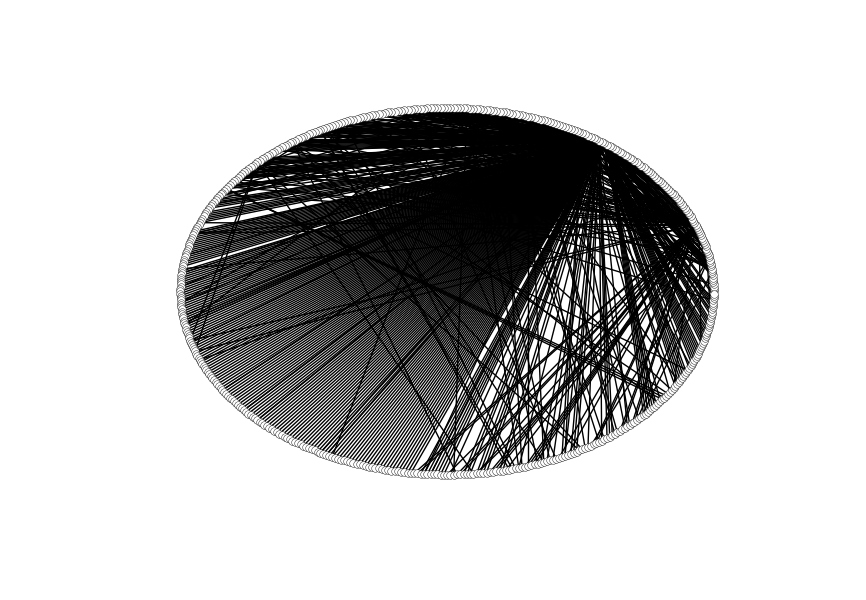

In [62]:
nx.draw_circular(G, node_size=30, node_color='white')
plt.show()

Like we can see, there are a lot of nodes and links and thus graph is not relevant at all. Let's try with the `community` tools to find partitions and at the same time fetch emails for each community.

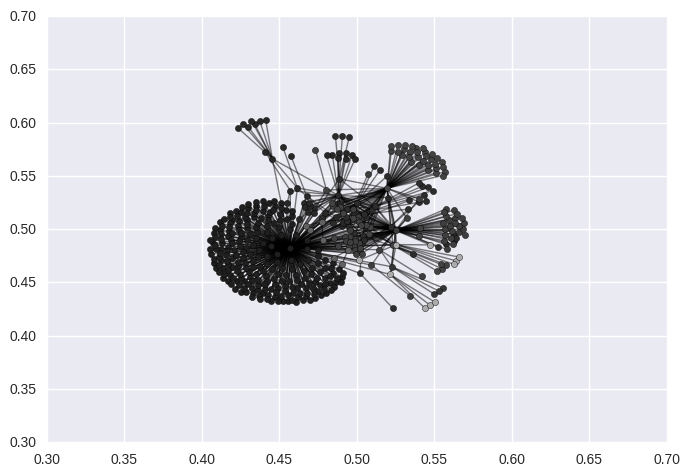

In [63]:
# Base on example provided here: http://perso.crans.org/aynaud/communities/index.html
partition = community.best_partition(G)

size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
communities = {}
for communityId in set(partition.values()):
    
    # Build graph
    count = count + 1
    list_nodes = [partition_nodes for partition_nodes in partition.keys() if partition[partition_nodes] == communityId]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=20, node_color=str(count / size))
    
    # Build communities with emails
    content = ''
    for personId in list_nodes:
        content += ' '.join([email.MetadataSubject + ' ' + email.ExtractedBodyText for email in df_emails.loc[df_emails['SenderPersonId'] == personId].itertuples()]).lower()
    communities[communityId] = {
        'document': content,
        'nodes': list_nodes,
        'counter': Counter(content.split())
    }

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.axis([0.3, 0.7, 0.3, 0.7])
plt.show()

In [64]:
print('Number of communities: ' + str(len(set(partition.values()))))

Number of communities: 58


We can see that there is only one real community (with Clinton at the middle for sure) and few others, with limited links.

Note that because of some limited conversations (few mails sent by some people), the obtained graph is not much readable. Also, the number of topics is quite high, and some of them will not be really relevant (see below).

Finally, we can retrieve the most used words in each community.

In [65]:
for key, com in communities.items():
    print('Topic ' + str(key) + ' : ' + ', '.join(['"'+ word + '" (' + str(number) + ')' for word, number in com['counter'].most_common(20)]) + '\n')

Topic 0 : "a" (1), "bill" (1)

Topic 1 : "s-aqmpd-07-c0054" (1), "no." (1), "attachment" (1), "5" (1), "contract" (1), "-" (1)

Topic 2 : "us" (1), "in" (1), "betrayed" (1), "war:" (1), "general" (1), "envoy" (1), "me" (1), "top" (1), "afghan" (1)

Topic 3 : "to" (3), "u.s." (3), "opinion" (2), "europe:" (2), "in" (2), "unasur" (2), "demarche/letter" (2), "haiti" (2), "for" (2), "prior" (2), "august" (2), "summit" (2), "28" (2), "wary" (1), "be" (1), "publics" (1), ""al" (1), "trap"" (1), "relief" (1), "yemen" (1)

Topic 4 : "following" (1), "core" (1), "for" (1), "areas" (1), "discussed" (1), "activity" (1), "last" (1), "proposed" (1), "benchmarks" (1), "of" (1), "as" (1), "are" (1), "we" (1), "week" (1)

Topic 5 : "wake-up" (1), "haiti" (1), "a" (1), "beyond" (1), "call" (1), "for" (1), "the" (1), "earthquake:" (1)

Topic 6 : "the" (2501), "to" (2066), "and" (1527), "i" (1175), "of" (1039), "a" (967), "you" (958), "in" (946), "for" (807), "is" (667), "on" (636), "that" (483), "can" (

Using communities is another way to retrieve topics among content. As we can see, we have some topics that we found in part 3, like conflict in Middle-East (topic 42), Afghanistan (topic 46), Pakistan (topic 52), Secretary's daily job (topics 20 and 41).

However, there are two limitations here. First, we still have garbage (topic 39 for example). Second, we clearly see that for the global majority of topics, keywords are linked with one and only one email - two at most 5this is due to the fact that we have a lot of small communities here); thus, it is difficult to make a clear conclusion on what we get and further analysis must be done.